C:\Users\Danie\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Data loaded: 900000 samples, 21 features

AGGLOMERATIVE CLUSTERING METRICS
Silhouette          : 0.2721
Calinski Harabasz   : 1773.7674
Davies Bouldin      : 1.5722
Adjusted Rand       : -0.0249


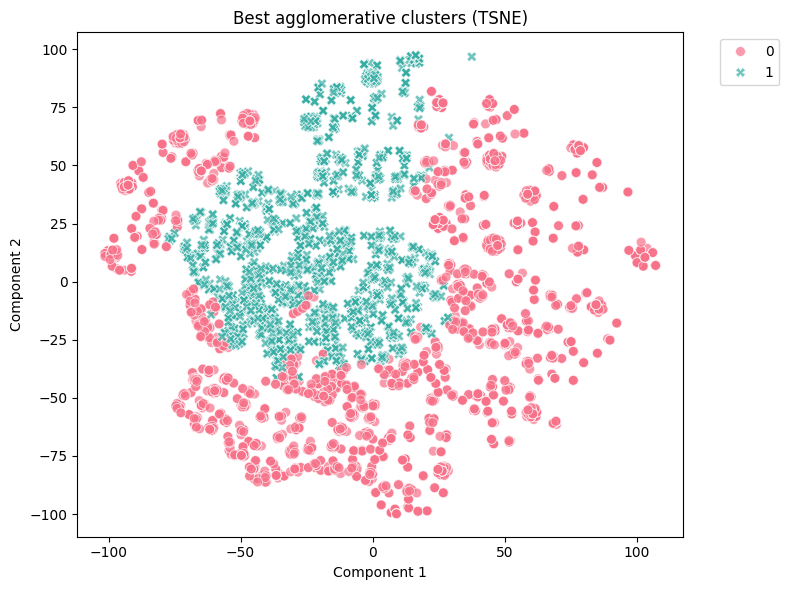


DBSCAN CLUSTERING METRICS
Silhouette          : 0.4640
Calinski Harabasz   : 40.2770
Davies Bouldin      : 0.9251
Adjusted Rand       : 0.0159


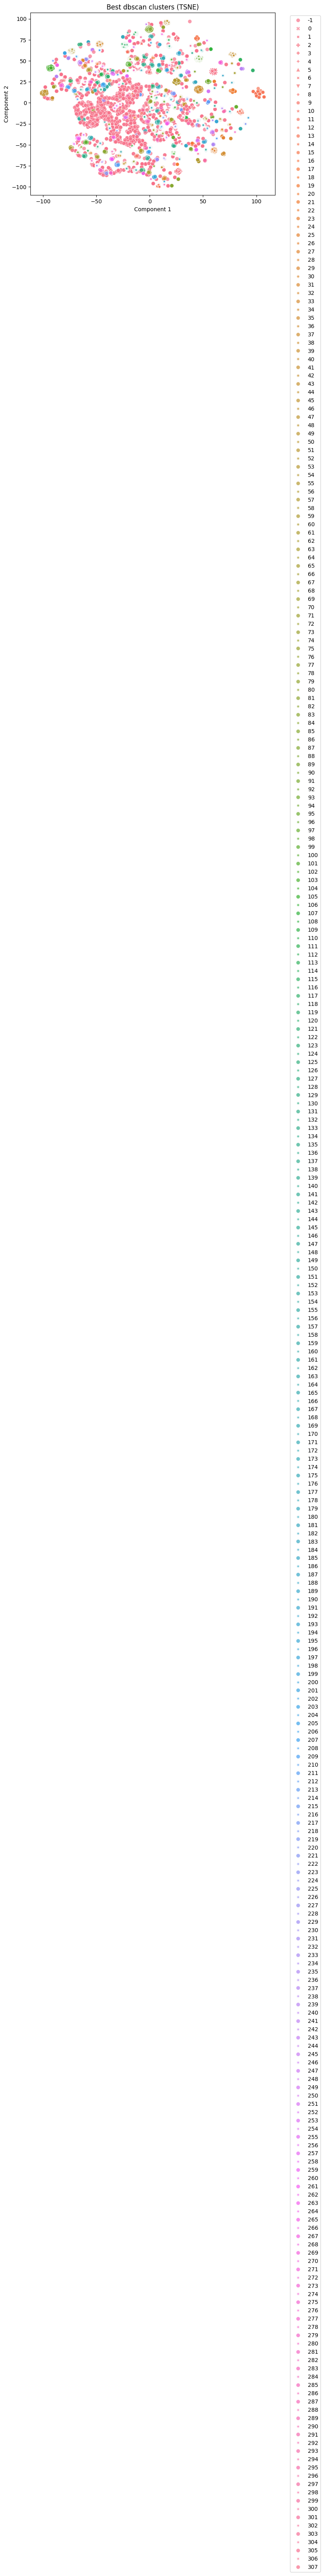


KMEANS CLUSTERING METRICS
Silhouette          : 0.3259
Calinski Harabasz   : 2328.0753
Davies Bouldin      : 1.0344
Adjusted Rand       : -0.0024


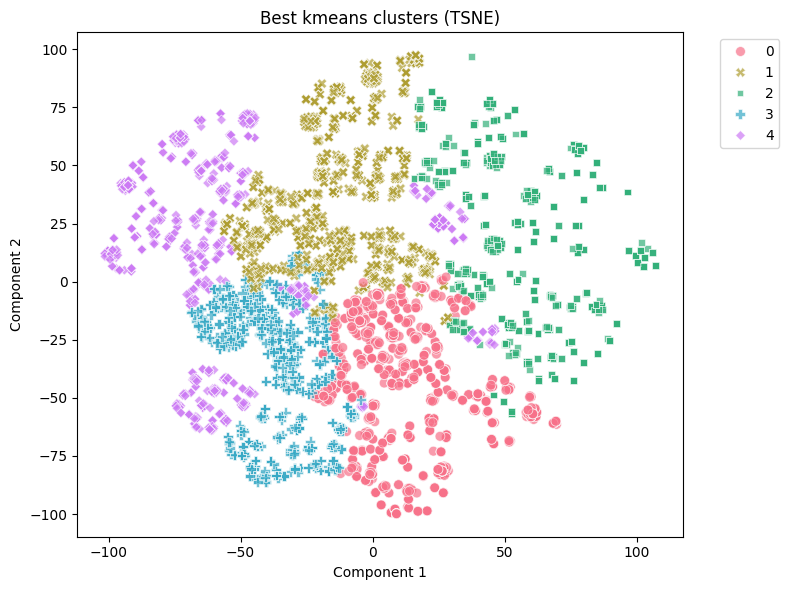


Full results saved to clustering_results.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import (
    adjusted_rand_score, silhouette_score,
    calinski_harabasz_score, davies_bouldin_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings

warnings.filterwarnings('ignore')

# =============================================
# 1. DATA PREPARATION
# =============================================
def load_and_preprocess():
    """Load and preprocess the blackjack dataset"""
    try:
        df = pd.read_csv("BLK.csv")
        print(f"Data loaded: {df.shape[0]} samples, {df.shape[1]} features")

        # Clean target and filter
        df["blkjck"] = (
            df["blkjck"].astype(str)
            .str.strip()
            .str.lower()
            .map({"win": 1, "nowin": 0, "true": 1, "false": 0})
        )
        df = df[df["blkjck"].isin([0, 1])]

        # Feature engineering
        features = ["card1", "card2", "dealcard1"]
        X = df[features]
        y = df["blkjck"]

        # Scaling
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        return X_scaled, y, df

    except Exception as e:
        print(f"Data loading failed: {str(e)}")
        raise

# =============================================
# 2. CLUSTERING ALGORITHMS
# =============================================
def run_kmeans(X, n_clusters=2, random_state=42):
    """K-Means clustering with multiple metrics"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)
    return {
        'labels': labels,
        'centroids': kmeans.cluster_centers_,
        'inertia': kmeans.inertia_
    }

def run_agglomerative(X, n_clusters=2, linkage='ward'):
    """Hierarchical clustering with memory efficiency"""
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    return agg.fit_predict(X)

def run_dbscan(X, eps=0.5, min_samples=5):
    """Density-based clustering"""
    db = DBSCAN(eps=eps, min_samples=min_samples)
    return db.fit_predict(X)

# =============================================
# 3. VISUALIZATION TOOLS
# =============================================
def plot_clusters(X, labels, title, method='pca'):
    """Visualize clusters using dimensionality reduction"""
    plt.figure(figsize=(8, 6))

    reducer = PCA(n_components=2) if method == 'pca' else TSNE(n_components=2, perplexity=30)
    X_reduced = reducer.fit_transform(X)

    palette = sns.color_palette("husl", len(np.unique(labels)))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1],
                    hue=labels, palette=palette,
                    style=labels, s=50, alpha=0.7)

    plt.title(f"{title} ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# =============================================
# 4. EVALUATION FRAMEWORK
# =============================================
def evaluate_clusters(X, labels, true_labels=None):
    """Compute multiple clustering metrics"""
    metrics = {}
    n_clusters = len(np.unique(labels))

    if n_clusters > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)

    if true_labels is not None:
        metrics['adjusted_rand'] = adjusted_rand_score(true_labels, labels)

    return metrics

def print_metrics(metrics, algorithm):
    """Pretty print evaluation metrics"""
    print(f"\n{'=' * 40}")
    print(f"{algorithm.upper()} CLUSTERING METRICS")
    print('=' * 40)
    for name, value in metrics.items():
        print(f"{name.replace('_', ' ').title():<20}: {value:.4f}")

# =============================================
# 5. HYPERPARAMETER EXPERIMENTS
# =============================================
def parameter_grid_search(X, y=None):
    """Test multiple parameter combinations"""
    results = []

    for k in [2, 3, 4, 5]:
        res = run_kmeans(X, n_clusters=k)
        metrics = evaluate_clusters(X, res['labels'], y)
        results.append({
            'algorithm': 'kmeans',
            'params': {'n_clusters': k},
            'metrics': metrics,
            'labels': res['labels']
        })

    for linkage in ['ward', 'complete', 'average']:
        labels = run_agglomerative(X, linkage=linkage)
        metrics = evaluate_clusters(X, labels, y)
        results.append({
            'algorithm': 'agglomerative',
            'params': {'linkage': linkage},
            'metrics': metrics,
            'labels': labels
        })

    for eps, min_samples in product([0.3, 0.5, 0.7], [5, 10, 15]):
        labels = run_dbscan(X, eps=eps, min_samples=min_samples)
        metrics = evaluate_clusters(X, labels, y)
        results.append({
            'algorithm': 'dbscan',
            'params': {'eps': eps, 'min_samples': min_samples},
            'metrics': metrics,
            'labels': labels
        })

    return pd.DataFrame(results)

# =============================================
# MAIN EXECUTION
# =============================================
if __name__ == "__main__":
    X, y, df = load_and_preprocess()

    # Sampling for memory-intensive methods
    sample_idx = np.random.choice(len(X), size=5000, replace=False)
    X_sample, y_sample = X[sample_idx], y.iloc[sample_idx]

    # Run grid search
    results = parameter_grid_search(X_sample, y_sample)

    # Fix: Properly extract best result per algorithm based on silhouette score
    def get_best_indices(df):
        best_indices = []
        for name, group in df.groupby('algorithm'):
            scores = group['metrics'].apply(lambda m: m.get('silhouette', -1))
            idx = scores.idxmax()
            best_indices.append(idx)
        return best_indices

    best_indices = get_best_indices(results)
    best_results = results.loc[best_indices]

    # Display and visualize best results
    for _, row in best_results.iterrows():
        print_metrics(row['metrics'], row['algorithm'])
        plot_clusters(X_sample, row['labels'], title=f"Best {row['algorithm']} clusters", method='tsne')

    # Save results
    results.to_csv('clustering_results.csv', index=False)
    print("\nFull results saved to clustering_results.csv")
